# Interpretable extreme wind speed prediction with concept bottleneck models

## Imports

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import random
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from matplotlib.gridspec import GridSpec
seeed = 38#15
random.seed(seeed)
np.random.seed(seeed)
import warnings
warnings.filterwarnings('ignore')

## Dataset

The dataset containing the Wind Speed Series is loaded.

In [59]:
df = pd.read_csv(r"Pena_Wind.csv", index_col='Unnamed: 0')

The dataset is divided in train and test, and the train dataset is used to stablish both umbrals of classification.

In [60]:
train_df= df.loc['2003-01-01 00:00:00':'2010-12-31 23:00:00']
test_df= df.loc['2011-01-01 00:00:00':'2012-12-31 23:00:00']

umbral_df=df.loc['2003-01-01 00:00:00':'2010-12-31 23:00:00']
m_w = umbral_df['Wind'].mean()
s_w = umbral_df['Wind'].std()
umbral_a = m_w + 2*s_w
umbral_b = m_w + 3*s_w

In [61]:
print('Umbral A: ', round(umbral_a,2))
print('Umbral B: ', round(umbral_b,2))

Umbral A:  17.2
Umbral B:  21.92


Visualization of the Wind Speed distribution and the thresholds of classification.

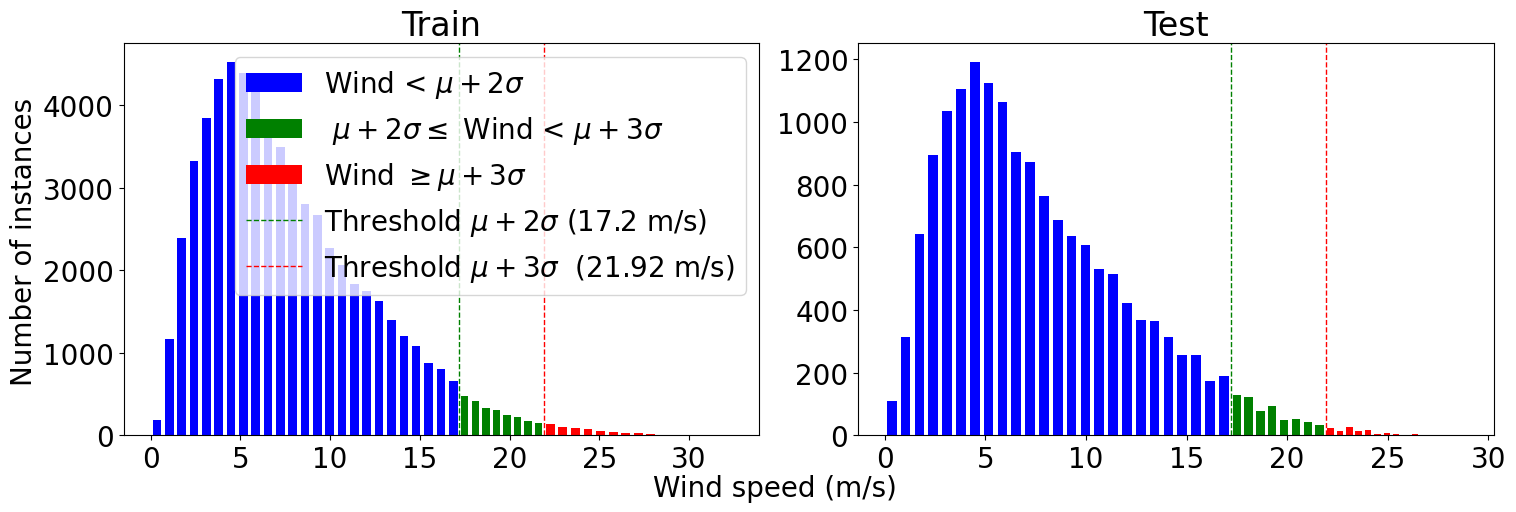

In [62]:
# Configuración de la figura y subgráficos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Configuración del primer subplot (izquierda)
axs[0].hist(train_df[train_df['Wind'] < umbral_a], bins=25, color='blue', rwidth=0.7, label='Wind < $\mu + 2\sigma$')
axs[0].hist(train_df[(train_df['Wind']> umbral_a)&(train_df['Wind']< umbral_b)], bins=8, color='green',  rwidth=0.7, label=' $\mu + 2\sigma \leq$ Wind < $\mu + 3\sigma$')
axs[0].hist(train_df[train_df['Wind'] > umbral_b]['Wind'], bins=15, color='red',  rwidth=0.7, label='Wind $\geq \mu + 3\sigma$')
axs[0].axvline(umbral_a, color='green', linestyle='dashed', linewidth=1, label='Threshold $\mu + 2\sigma$ (' + str(umbral_a.round(2)) + ' m/s)')
axs[0].axvline(umbral_b, color='red', linestyle='dashed', linewidth=1, label='Threshold $\mu + 3\sigma$  (' + str(umbral_b.round(2)) + ' m/s)')
axs[0].set_title('Train')
axs[0].legend()

# Configuración del segundo subplot (derecha) - el mismo que el primero
axs[1].hist(test_df[test_df['Wind'] < umbral_a], bins=25, color='blue', rwidth=0.7, label='Non extreme events')
axs[1].hist(test_df[(test_df['Wind']> umbral_a)&(test_df['Wind']< umbral_b)], bins=8, color='green',  rwidth=0.7, label='Extreme events')
axs[1].hist(test_df[test_df['Wind'] > umbral_b]['Wind'], bins=15, color='red', rwidth=0.7, label='Extreme events')
axs[1].axvline(umbral_a, color='green', linestyle='dashed', linewidth=1, label='Discrimination Threshold (' + str(umbral_a.round(2)) + ' m/s)')
axs[1].axvline(umbral_b, color='red', linestyle='dashed', linewidth=1, label='EWS Threshold (' + str(umbral_b.round(2)) + ' m/s)')
axs[1].set_title('Test')
#axs[1].legend()
fig.text(0.5, -0.01, 'Wind speed (m/s)', ha='center')
fig.text(-0.01, 0.5, 'Number of instances', va='center', rotation='vertical')
plt.rc('font', size=12)


# Ajustar el diseño para evitar solapamiento
plt.tight_layout()

# Mostrar la figura
plt.show()


## Model

The dataset is transformed into de OHLC features and the target variable is created. The target variable is 1 if the wind speed is greater than the threshold and 0 otherwise.

In [63]:
def scalador(train,test):
    scaler=StandardScaler()
    scaler.fit(train)
    train_scaled=scaler.transform(train)
    train_scaled=pd.DataFrame(train_scaled)
    train_scaled.columns=train.columns
    train_scaled.index=train.index
    test_scaled=scaler.transform(test)
    test_scaled=pd.DataFrame(test_scaled)
    test_scaled.columns=test.columns
    test_scaled.index=test.index
    return train_scaled,test_scaled, scaler

forward=1

def df_generator(df,column,forward,umbral_a,umbral_b):
    df_new=df.loc[:,[column]].copy()
    W = [3,6,12,24]
    for w in W:
        df_new['M_'+str(w)]=df_new[column] - df_new[column].rolling(window=w).mean()
        if w > 3:
            df_new['O_'+str(w)]=df_new[column].shift(w-1)
            df_new['H_'+str(w)]=df_new[column].rolling(window=w).max()
            df_new['L_'+str(w)]=df_new[column].rolling(window=w).min()
    df_new['Wind_f']=df['Wind'].shift(-forward)
    #definir como 0 los valores de viento menor al umbral
    df_new['Wind_f_1']=np.where(df_new['Wind_f'] < umbral_a, 0, 1)
    df_new['Wind_f_3']=np.where(df_new['Wind_f'] < umbral_b, 0, 1)
    #change the name of the column to close
    df_new.rename(columns={column:'C'}, inplace=True)
    df_new=df_new.dropna()
    return df_new

column='Wind'
tr_dataset=df_generator(train_df,column,forward,umbral_a,umbral_b)
ts_dataset=df_generator(test_df,column,forward,umbral_a,umbral_b)
tr_dataset_new,ts_dataset_new, scaler=scalador(tr_dataset,ts_dataset)
tr_dataset_new['Wind_f']=tr_dataset['Wind_f']
ts_dataset_new['Wind_f']=ts_dataset['Wind_f']
tr_dataset_new['Wind_f_1']=tr_dataset['Wind_f_1']
ts_dataset_new['Wind_f_1']=ts_dataset['Wind_f_1']
tr_dataset_new['Wind_f_3']=tr_dataset['Wind_f_3']
ts_dataset_new['Wind_f_3']=ts_dataset['Wind_f_3']


X_tr=tr_dataset_new.drop(columns=['Wind_f','Wind_f_1','Wind_f_3'])
y_tr=tr_dataset_new['Wind_f']
y_tr_a=tr_dataset_new['Wind_f_1']
y_tr_b=tr_dataset_new['Wind_f_3']
X_ts=ts_dataset_new.drop(columns=['Wind_f','Wind_f_1','Wind_f_3'])
y_ts=ts_dataset_new['Wind_f']
y_ts_a=ts_dataset_new['Wind_f_1']
y_ts_b=ts_dataset_new['Wind_f_3']

The concept generator is defined.

In [64]:
def concept_generator(X_tr, y_tr, X_ts, y_ts):
    tree_name = 0
    or_columns = X_tr.columns
    adaboost_concept = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4, class_weight='balanced',splitter='random'), n_estimators=16, random_state=seeed)
    adaboost_concept.fit(X_tr, y_tr)
    new_X_tr = X_tr.copy()
    new_X_ts = X_ts.copy()
    concept_rules = {}
    def find_path(node_numb, path, x):
        path.append(node_numb)
        if node_numb == x:
            return True
        left = False
        right = False
        if (children_left[node_numb] !=-1):
            left = find_path(children_left[node_numb], path, x)
        if (children_right[node_numb] !=-1):
            right = find_path(children_right[node_numb], path, x)
        if left or right :
            return True
        path.remove(node_numb)
        return False
    def get_rule(path, column_names):
        mask = ''
        for index, node in enumerate(path):
            # Verificamos si no estamos en la hoja
            if index != len(path) - 1:
                # ¿Vamos por debajo o por encima del umbral?
                if children_left[node] == path[index + 1]:
                    mask += "({} <= {}) \t ".format(column_names[feature[node]], threshold[node])
                else:
                    mask += "({} > {}) \t ".format(column_names[feature[node]], threshold[node])
        # Insertamos los operadores "&" en los lugares correctos
        mask = mask.replace("\t", "&", mask.count("\t") - 1)
        mask = mask.replace("\t", "")
        return mask 
    rule_name = 0
    for tree in adaboost_concept.estimators_:
        tree_name +=1
        children_left = tree.tree_.children_left
        children_right = tree.tree_.children_right
        threshold = tree.tree_.threshold
        feature = tree.tree_.feature
        leaves_id = np.unique(tree.apply(X_tr))
        classes = tree.tree_.value[leaves_id].argmax(axis=2).squeeze()
        pos_leaves_id = leaves_id[classes == 1]
        paths = {}
        for leaf in pos_leaves_id:
            path_leaf = []
            find_path(0, path_leaf, leaf)
            paths[leaf] = np.unique(np.sort(path_leaf))
        rules= {}
        for key in paths:
            rules[key] = get_rule(paths[key], X_tr.columns)
        new_columns = [str(rule_name+i) for i in range(0, len(rules))]
        new_X_tr_zeros = pd.DataFrame(np.zeros((len(new_X_tr), len(new_columns))), index=new_X_tr.index, columns=new_columns)
        new_X_tr = pd.concat([new_X_tr, new_X_tr_zeros], axis=1)

        new_X_ts_zeros = pd.DataFrame(np.zeros((len(new_X_ts), len(new_columns))), index=new_X_ts.index, columns=new_columns)
        new_X_ts = pd.concat([new_X_ts, new_X_ts_zeros], axis=1)

        # Aplicar las reglas a los conjuntos de entrenamiento y prueba

        for i, (key, rule) in enumerate(rules.items()):
            index_rule_tr = X_tr.query(rule).index
            index_rule_test = X_ts.query(rule).index
            new_X_tr.loc[index_rule_tr, new_columns[i]] = 1
            new_X_ts.loc[index_rule_test, new_columns[i]] = 1
            concept_rules[str(rule_name)] = rule
            rule_name+=1

    final_X_tr = new_X_tr
    final_X_tr = final_X_tr.drop(columns=or_columns)
    final_y_tr = y_tr
    final_X_ts = new_X_ts
    final_X_ts = final_X_ts.drop(columns=or_columns)
    final_y_ts = y_ts
    return final_X_tr, final_y_tr, final_X_ts, final_y_ts, concept_rules

Concepts for the first threshold are generated.

In [65]:
final_X_tr, final_y_tr, final_X_ts, final_y_ts, concept_rules = concept_generator(X_tr, y_tr_a, X_ts, y_ts_a)

The first classifier is trained, and used to do the first classification.

In [66]:
params = {'C' : np.logspace(-4, 3, 20), 'penalty' : ['l1', 'l2']}
LR = GridSearchCV(LogisticRegression(solver='liblinear', class_weight=None,random_state=seeed), params, cv=5, scoring='f1')
LR.fit(final_X_tr, final_y_tr)

LR_sel = LR.best_estimator_
selector = RFECV(LR_sel, step=1, cv=5, scoring='f1')
selector = selector.fit(final_X_tr, final_y_tr)
sel_X_tr = selector.transform(final_X_tr)
sel_X_ts = selector.transform(final_X_ts)
LR.fit(sel_X_tr, final_y_tr)
y_pred_tr = LR.predict(sel_X_tr)
y_pred_ts = LR.predict(sel_X_ts)

LR_acc = accuracy_score(final_y_ts, y_pred_ts)
LR_prec = precision_score(final_y_ts, y_pred_ts)
LR_recall = recall_score(final_y_ts, y_pred_ts)
LR_f1 = f1_score(final_y_ts, y_pred_ts)
LR_matrix = confusion_matrix(final_y_ts, y_pred_ts)

X_tr_2 = X_tr[y_pred_tr == 1]
y_tr_2 = y_tr_b[y_pred_tr == 1]
X_ts_2 = X_ts[y_pred_ts == 1]
y_ts_2 = y_ts_b[y_pred_ts == 1]

model_1 = LR.best_estimator_
weights = model_1.coef_
non_zero_weights = np.where(weights != 0)[1]
X_1 = sel_X_tr[:, non_zero_weights]
num_con = X_1.sum(axis=1)
num_con = pd.DataFrame(num_con)



Concepts for the second threshold are generated and concatenated to the ones coming from the first.

In [67]:
final_X_tr_2, final_y_tr_2, final_X_ts_2, final_y_ts_2, concept_rules_2 = concept_generator(X_tr, y_tr_b, X_ts_2, y_ts_2)


final_X_tr_2 = final_X_tr_2[y_pred_tr == 1]
final_y_tr_2 = final_y_tr_2[y_pred_tr == 1]


final_X_tr_3 = pd.concat([final_X_tr[y_pred_tr == 1], final_X_tr_2], axis=1)
final_X_ts_3 = pd.concat([final_X_ts[y_pred_ts == 1], final_X_ts_2], axis=1)


The second classifier is trained, and the final clasification is performed.

In [68]:
LR_3 = GridSearchCV(LogisticRegression(solver='liblinear', class_weight=None,random_state=seeed), params, cv=5, scoring='f1')
LR_3.fit(final_X_tr_3, final_y_tr_2)
LR_sel_3 = LR_3.best_estimator_
selector_3 = RFECV(LR_sel_3, step=1, cv=5, scoring='f1')
selector_3 = selector_3.fit(final_X_tr_3, final_y_tr_2)
sel_X_tr_3 = selector_3.transform(final_X_tr_3)
sel_X_ts_3 = selector_3.transform(final_X_ts_3)
LR_3.fit(sel_X_tr_3, final_y_tr_2)
y_pred_tr_3 = LR_3.predict(sel_X_tr_3)
y_pred_ts_3 = LR_3.predict(sel_X_ts_3)
total_y_ts_pred_2 = pd.Series(np.zeros(len(y_ts)), index=y_ts.index)
idx_3 = final_y_ts_2[y_pred_ts_3 == 1].index
total_y_ts_pred_2[idx_3] = 1
LR_3_acc = accuracy_score(y_ts_b, total_y_ts_pred_2)
LR_3_prec = precision_score(y_ts_b, total_y_ts_pred_2)
LR_3_recall = recall_score(y_ts_b, total_y_ts_pred_2)
LR_3_f1 = f1_score(y_ts_b, total_y_ts_pred_2)
LR_3_matrix = confusion_matrix(y_ts_b, total_y_ts_pred_2)
model_3 = LR_3.best_estimator_
weights_3 = model_3.coef_
non_zero_weights_3 = np.where(weights_3 != 0)[1]
X_3 = sel_X_tr_3[:, non_zero_weights_3]
num_con_3 = X_3.sum(axis=1)
num_con_3 = pd.DataFrame(num_con_3)

## Results

In [69]:
res = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision','Recall', 'F1', 'TN', 'FN', 'FP', 'TP', 'Num_concepts', 'Min', 'Max', 'perc_50'])
res.loc[0] = ['LR', LR_acc, LR_prec, LR_recall, LR_f1, LR_matrix[0][0], LR_matrix[1][0], LR_matrix[0][1], LR_matrix[1][1], non_zero_weights.shape[0], num_con.min()[0], num_con.max()[0], num_con.median()[0]]
res.loc[1] = ['LR_3', LR_3_acc, LR_3_prec, LR_3_recall, LR_3_f1, LR_3_matrix[0][0], LR_3_matrix[1][0], LR_3_matrix[0][1], LR_3_matrix[1][1], non_zero_weights_3.shape[0], num_con_3.min()[0], num_con_3.max()[0], num_con_3.median()[0]]
res

,Model,Accuracy,Precision,Recall,F1,TN,FN,FP,TP,Num_concepts,Min,Max,perc_50
0,LR,0.979192,0.819473,0.685908,0.746765,12490,185,89,404,19,0.0,6.0,0.0
1,LR_3,0.995064,0.717172,0.657407,0.685990,13032,37,28,71,8,0.0,5.0,2.0


## Rules Visualization and statistics

In [70]:
all_the_rules_1 = {str(key): value for (key, value) in concept_rules.items()}
all_the_rules_2 = {str(int(key) + len(all_the_rules_1)): value for (key, value) in concept_rules_2.items()}
all_the_rules = {**all_the_rules_1, **all_the_rules_2}


In [71]:
used_conc = selector_3.support_
used_conc = np.where(used_conc == True)[0]
used_conc = [str(i) for i in used_conc]

In [72]:
pos_1 = pd.DataFrame(X_1[y_tr_a==1].sum(axis=1)).value_counts()
neg_1 = pd.DataFrame(X_1[y_tr_a==0].sum(axis=1)).value_counts()
pn_1 = pd.concat([pos_1, neg_1], axis=1).sort_index()
pn_1.columns = ['Pos', 'Neg']
pn_1 = pn_1.fillna(0)
pos_3 = pd.DataFrame(X_3[final_y_tr_2==1].sum(axis=1)).value_counts()
neg_3 = pd.DataFrame(X_3[final_y_tr_2==0].sum(axis=1)).value_counts()
pn_3 = pd.concat([pos_3, neg_3], axis=1).sort_index()
pn_3.columns = ['Pos', 'Neg']
pn_3 = pn_3.fillna(0)

In [73]:
pos_21 = pd.DataFrame(X_1[(y_tr_a==1)&(y_tr_b==0)].sum(axis=1)).value_counts()
neg_22 = pd.DataFrame(X_1[(y_tr_b==1)].sum(axis=1)).value_counts()
neg_2 = pd.DataFrame(X_1[y_tr_a==0].sum(axis=1)).value_counts()
pn_2 = pd.concat([pos_21, neg_22, neg_2], axis=1).sort_index()
pn_2.columns = ['Pos1', 'Pos2', 'Neg']
pn_2 = pn_2.fillna(0)

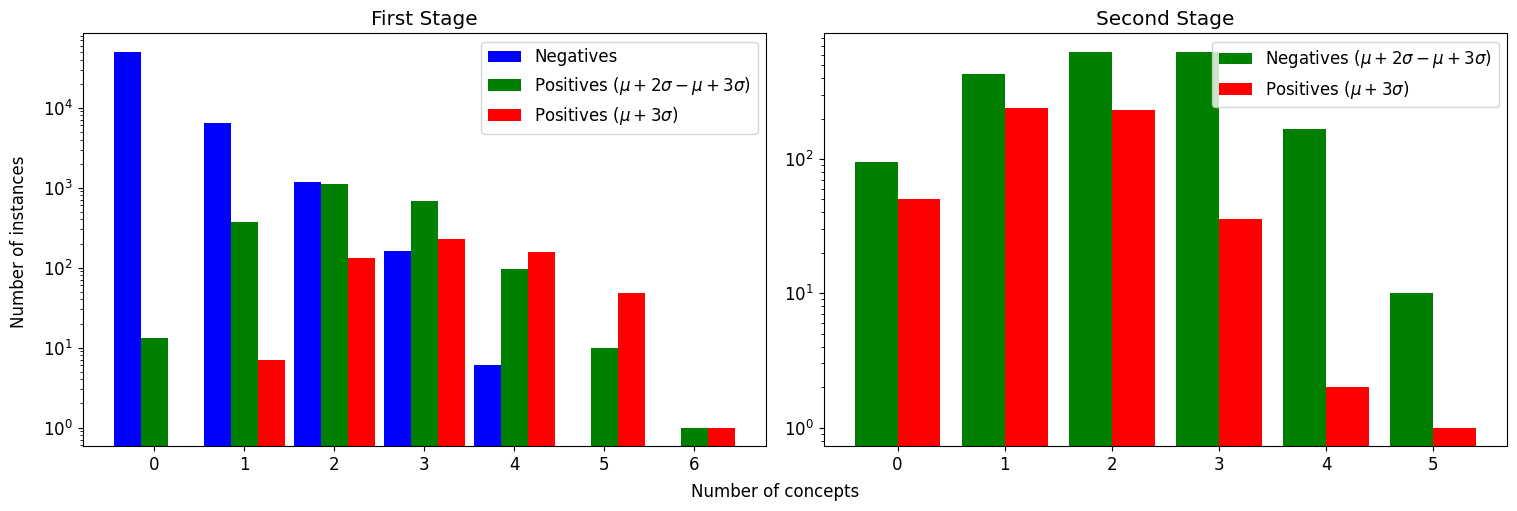

In [74]:
# Configuración de la figura y subgráficos
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Configuración del primer subplot (izquierda)

labels = pn_1.index
x = np.arange(len(labels))
bar_width = 0.3
axs[0].bar(x - bar_width , pn_2['Neg'], bar_width, label='Negatives', color='blue')
axs[0].bar(x  , pn_2['Pos1'], bar_width, label='Positives ($\mu+2\sigma-\mu+3\sigma$)', color='green')
axs[0].bar(x + bar_width, pn_2['Pos2'], bar_width, label='Positives ($\mu+3\sigma$)', color='red')
# Dibujar las barras de Negatives
axs[0].set_yscale('log')
axs[0].set_title('First Stage')
axs[0].legend()


labels_2 = pn_3.index
x_2 = np.arange(len(labels_2))
bar_width_2 = 0.4
axs[1].bar(x_2 - bar_width_2 / 2, pn_3['Neg'], bar_width_2, label='Negatives ($\mu+2\sigma-\mu+3\sigma$)', color='green')
axs[1].bar(x_2 + bar_width_2 / 2, pn_3['Pos'], bar_width_2, label='Positives ($\mu+3\sigma$)', color='red')
# Dibujar las barras de Negatives
axs[1].set_yscale('log')
axs[1].set_title('Second Stage')
axs[1].legend()

fig.text(0.5, -0.01, 'Number of concepts', ha='center')
fig.text(-0.01, 0.5, 'Number of instances', va='center', rotation='vertical')
plt.rc('font', size=12)


# Ajustar el diseño para evitar solapamiento
plt.tight_layout()

# Mostrar la figura
plt.show()


In [75]:
def decision_df(model, x_tr, y_tr, x_ts, y_ts):
    y_tr_pred = model.predict(x_tr)
    y_ts_pred = model.predict(x_ts)
    
    pand = pd.DataFrame()
    
    x_tr = pd.DataFrame(x_tr)
    x_ts = pd.DataFrame(x_ts)
    
    filas_unicas = x_tr.drop_duplicates().values
    
    pand['vectors'] = filas_unicas.tolist()
    pand['n decisiones'] = pand['vectors'].apply(lambda x: sum(x))
    
    frecuencia_tr, pos_tr, neg_tr, tp_tr, fp_tr, tn_tr, fn_tr = [], [], [], [], [], [], []
    frecuencia_ts, pos_ts, neg_ts, tp_ts, fp_ts, tn_ts, fn_ts = [], [], [], [], [], [], []

    for i in range(len(filas_unicas)):
        current_vector = filas_unicas[i]

        frecuencia_tr.append(np.sum((x_tr.values == current_vector).all(axis=1)))
        tp_tr.append(np.sum((x_tr.values == current_vector).all(axis=1) & (y_tr_pred == 1) & (y_tr == 1)))
        fp_tr.append(np.sum((x_tr.values == current_vector).all(axis=1) & (y_tr_pred == 1) & (y_tr == 0)))
        tn_tr.append(np.sum((x_tr.values == current_vector).all(axis=1) & (y_tr_pred == 0) & (y_tr == 0)))
        fn_tr.append(np.sum((x_tr.values == current_vector).all(axis=1) & (y_tr_pred == 0) & (y_tr == 1)))

        frecuencia_ts.append(np.sum((x_ts.values == current_vector).all(axis=1)))
        tp_ts.append(np.sum((x_ts.values == current_vector).all(axis=1) & (y_ts_pred == 1) & (y_ts == 1)))
        fp_ts.append(np.sum((x_ts.values == current_vector).all(axis=1) & (y_ts_pred == 1) & (y_ts == 0)))
        tn_ts.append(np.sum((x_ts.values == current_vector).all(axis=1) & (y_ts_pred == 0) & (y_ts == 0)))
        fn_ts.append(np.sum((x_ts.values == current_vector).all(axis=1) & (y_ts_pred == 0) & (y_ts == 1)))

    pand['frecuencia_tr'] = frecuencia_tr
    pand['tp_tr'] = tp_tr
    pand['fp_tr'] = fp_tr
    pand['tn_tr'] = tn_tr
    pand['fn_tr'] = fn_tr
    
    pand['frecuencia_ts'] = frecuencia_ts
    pand['tp_ts'] = tp_ts
    pand['fp_ts'] = fp_ts
    pand['tn_ts'] = tn_ts
    pand['fn_ts'] = fn_ts

    filas_unicas_ts = x_ts.drop_duplicates().values
    
    # Compare unique rows in test set with unique rows in training set
    conj_1 = set(tuple(x) for x in filas_unicas)
    conj_2 = set(tuple(x) for x in filas_unicas_ts)
    
    if conj_2.issubset(conj_1):
        print('The Test set is a subset of the Training set.')
    else:
        print('The Test set is not a subset of the Training set.')

    # Sort DataFrame based on the frequency in the training set
    pand = pand.sort_values(by=['frecuencia_tr'], ascending=False)
    pand = pand.reset_index(drop=True)
    
    return pand

In [76]:
dec_1 = decision_df(LR, sel_X_tr, final_y_tr, sel_X_ts, final_y_ts)

The Test set is not a subset of the Training set.


In [77]:
dec_1_p = decision_df(LR, sel_X_tr[y_tr_b==1], final_y_tr[y_tr_b==1], sel_X_ts, final_y_ts)

The Test set is not a subset of the Training set.


In [78]:
dec_3 = decision_df(LR_3, sel_X_tr_3, final_y_tr_2, sel_X_ts_3, final_y_ts_2)

The Test set is a subset of the Training set.


In [79]:
def visualizer_conceptos_pos_2(ds, subtitulo):

    fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
    labels = ds.index
    x = np.arange(len(labels))
    bar_width = 0.4

 
    ax1.bar(x - bar_width / 2, ds['fp'+ subtitulo].values, width=bar_width, color='red', label='False Positive')
    ax1.bar(x + bar_width / 2, ds['tp'+ subtitulo].values, width=bar_width, color='green', label='True Positive')
    ax1.legend()
    ax1.set_xticks(np.arange(0, len(ds)))
    ax1.set_xticklabels(np.arange(1, len(ds)+1))
    # ax1.set_title('Positive Classes')
    ax1.set_yscale('log')
    ax1.set_xlabel('Decisions')
    ax1.set_ylabel('Number of instances')

    plt.rc('font', size=12)
    plt.tight_layout()
    plt.show()

In [80]:
tr_cols_3 = [col for col in dec_3.columns if 'tr' in col]
tr_cols_1 = [col for col in dec_1.columns if 'tr' in col]

In [81]:
dec_1_pos = dec_1[(dec_1['tn_tr'] == 0) & (dec_1['fn_tr'] == 0)]
dec_1_pos = dec_1_pos.set_index(np.arange(0, len(dec_1_pos)))
dec_3_pos = dec_3[(dec_3['tn_tr'] == 0) & (dec_3['fn_tr'] == 0)]
dec_3_pos = dec_3_pos.set_index(np.arange(0, len(dec_3_pos)))

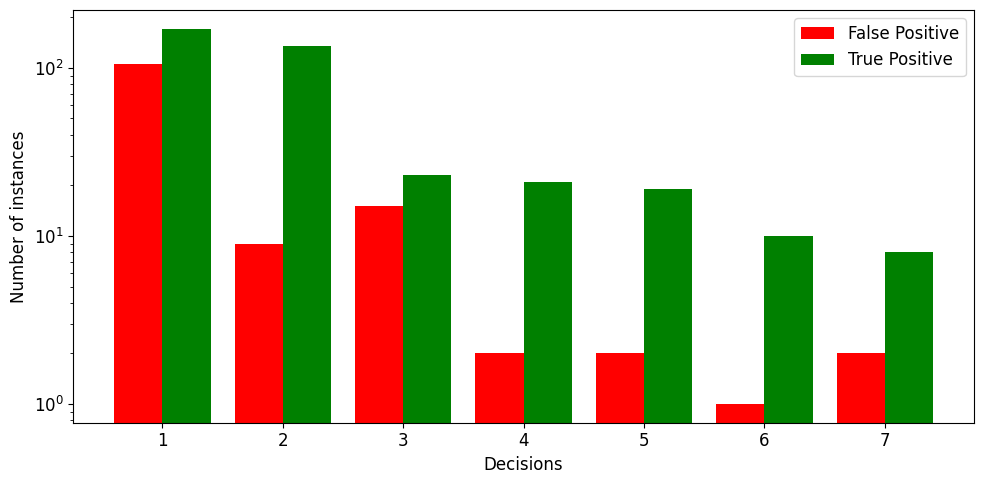

In [82]:
visualizer_conceptos_pos_2(dec_3_pos[tr_cols_3], '_tr')

In [83]:
matrix_of_concepts_1 = np.array(dec_1['vectors'].tolist())
matrix_of_concepts_pos_1 = np.array(dec_1_pos['vectors'].tolist())
columns_to_keep = np.any(matrix_of_concepts_pos_1 != 0, axis=0)
filtered_arr_1 = matrix_of_concepts_pos_1[:, columns_to_keep]
concept_names_1= np.arange(1, len(columns_to_keep)+1)
concept_names_pos_1 = concept_names_1[columns_to_keep]


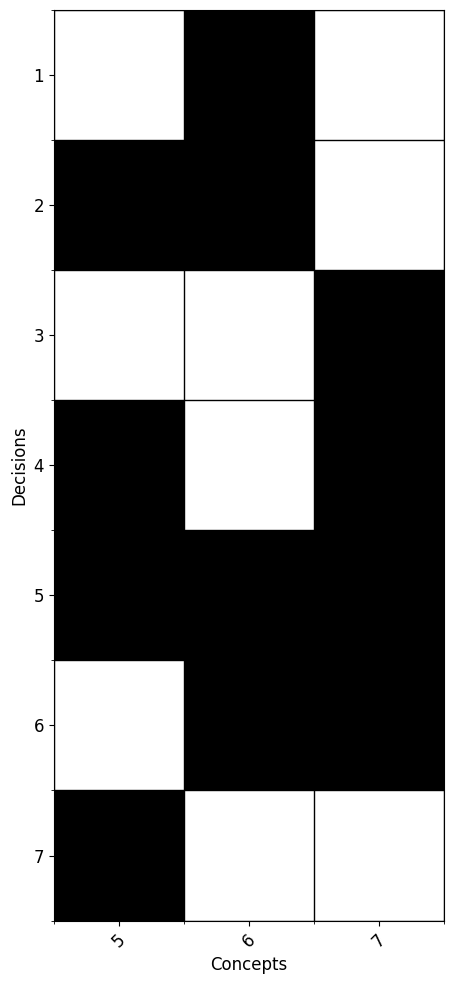

In [84]:
matrix_of_concepts_pos_3 = np.array(dec_3_pos['vectors'].tolist())
columns_to_keep = np.any(matrix_of_concepts_pos_3 != 0, axis=0)
filtered_arr_3 = matrix_of_concepts_pos_3[:, columns_to_keep]
concept_names_3= np.arange(1, len(columns_to_keep)+1)
concept_names_pos_3 = concept_names_3[columns_to_keep]

fig,ax = plt.subplots(figsize=(10,10))

ax.imshow(filtered_arr_3, cmap='binary')

ax.set_xticks(np.arange(-.5,filtered_arr_3.shape[1],1), minor=True)
ax.set_yticks(np.arange(-.5,filtered_arr_3.shape[0],1), minor=True)

ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

ax.set_xticks(np.arange(filtered_arr_3.shape[1]))
ax.set_xticklabels(concept_names_pos_3, rotation=45)
ax.set_yticks(np.arange(filtered_arr_3.shape[0]))
ax.set_yticklabels(np.arange(1, len(dec_3_pos)+1, 1))

ax.set_xlabel("Concepts")
ax.set_ylabel("Decisions")
#ax.set_title("Concept combinations")

fig.tight_layout()
plt.rc('font', size=20)

plt.show()

In [85]:
def get_rules(variables, rule):
    min_limits = {}
    max_limits = {}
    
    conditions = rule.split('&')
    
    variables_to_use = []

    for var in variables:
        min_limits[var] = None
        max_limits[var] = None
    
    for condition in conditions:
        parts = condition.strip().split()
        
        if len(parts) >= 3:
            var = parts[0].replace('(', '')  # Elimina paréntesis al principio
            if var not in variables_to_use:
                variables_to_use.append(var)
            if var in variables:
                operator = parts[1]
                num = float(parts[2].replace(')', ''))  # Elimina paréntesis al final
                
                if operator == '<=':
                    if max_limits[var] is None or num < max_limits[var]:
                        max_limits[var] = num
                elif operator == '>':
                    if min_limits[var] is None or num > min_limits[var]:
                        min_limits[var] = num
    
    min_series = pd.Series(min_limits)
    max_series = pd.Series(max_limits)
    
    return min_series, max_series, variables_to_use
def plot_rule(mins, maxs, min_int, max_int, variables,conc):
    # Crear subplots para cada variable
    fig, axs = plt.subplots(len(variables), figsize=(5, 1.2*int(len(variables))), facecolor='none')

    # Representar cada variable en su subgráfico
    for i, variable in enumerate(variables):
        # Obtener los valores de los intervalos
        minimo = mins[variable]
        maximo = maxs[variable]
        i_min = min_int[variable]
        i_max = max_int[variable]
        
        # Configurar los ejes x para cada subgráfico
        axs[i].set_xlim(minimo, maximo)

        # Representar las barras de los intervalos
        axs[i].barh(variable, maximo - minimo, left=minimo, height=0.3, color='white')
        axs[i].barh(variable, i_max - i_min, left=i_min, height=0.3, color='orange')

    plt.tight_layout()

    plt.show()
def plot_rule_2(mins, maxs, min_int, max_int, variables,conc):
    # Crear subplots para cada variable
    plt.figure(figsize=(5, 1*int(len(variables))), facecolor='none')
    minimo = mins[variables[0]]
    maximo = maxs[variables[0]]
    i_min = min_int[variables[0]]
    i_max = max_int[variables[0]]

    plt.xlim(minimo, maximo)

    # Representar las barras de los intervalos
    plt.barh(variables[0], maximo - minimo, left=minimo, height=0.3, color='white')
    plt.barh(variables[0], i_max - i_min, left=i_min, height=0.3, color='orange')
    
    #plt.xlabel('Valores')
    #plt.title('Concept '+str(conc) , y=0.95)
    plt.show()
def undo_scal(scaler, X):
    all_features= scaler.feature_names_in_
    sel_features= X.index
    new_X=pd.DataFrame(np.zeros((1, len(all_features))), columns=all_features)
    for feature in sel_features:
        new_X[feature]=X[feature]
    unscaled_new_X= pd.DataFrame(scaler.inverse_transform(new_X), columns=all_features)
    unscaled_X= unscaled_new_X[sel_features]
    return unscaled_X.squeeze()
def plot_concept(x,rule,scal,conc):
    mins=x.min()
    maxs=x.max()
    variables=x.columns
    min_int, max_int, variables_to_use = get_rules(variables,rule)
    for idx in min_int.index:
        if pd.isna(min_int[idx]) and pd.isna(max_int[idx]):
            min_int[idx] = 0
            max_int[idx] = 0
        elif pd.isna(min_int[idx]):
            min_int[idx] = mins[idx]
        elif pd.isna(max_int[idx]):
            max_int[idx] = maxs[idx]
    mins,maxs,min_int,max_int = undo_scal(scal,mins),undo_scal(scal,maxs),undo_scal(scal,min_int),undo_scal(scal,max_int)
    mins = mins[variables_to_use]
    maxs = maxs[variables_to_use]
    min_int = min_int[variables_to_use]
    max_int = max_int[variables_to_use]
    if len(variables_to_use) > 1:
        plot_rule(mins,maxs,min_int,max_int,variables_to_use,conc)
    else:
        plot_rule_2(mins,maxs,min_int,max_int,variables_to_use,conc)
    return 
def view_concept(x,rule,scal,conc):
    mins=x.min()
    maxs=x.max()
    variables=x.columns
    min_int, max_int, variables_to_use = get_rules(variables,rule)
    for idx in min_int.index:
        if pd.isna(min_int[idx]) and pd.isna(max_int[idx]):
            min_int[idx] = 0
            max_int[idx] = 0
        elif pd.isna(min_int[idx]):
            min_int[idx] = mins[idx]
        elif pd.isna(max_int[idx]):
            max_int[idx] = maxs[idx]
    mins,maxs,min_int,max_int = undo_scal(scal,mins),undo_scal(scal,maxs),undo_scal(scal,min_int),undo_scal(scal,max_int)
    
    mins = mins[variables_to_use]
    maxs = maxs[variables_to_use]
    min_int = min_int[variables_to_use]
    max_int = max_int[variables_to_use]

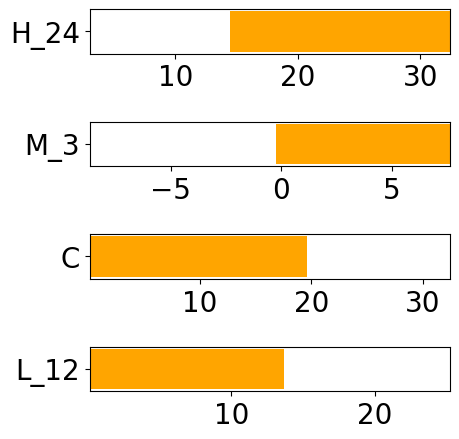

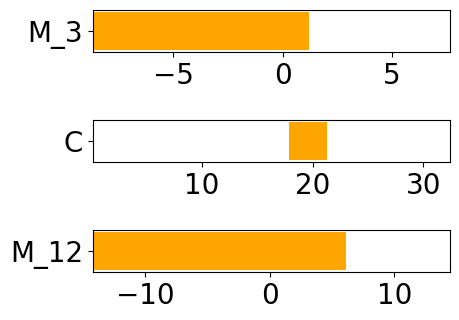

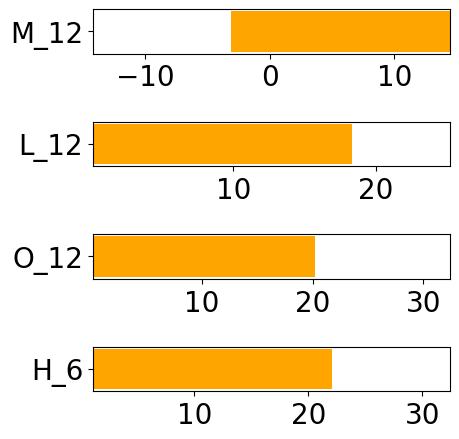

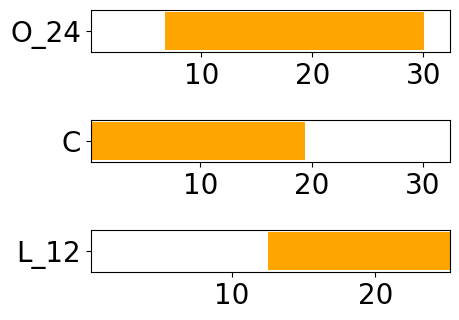

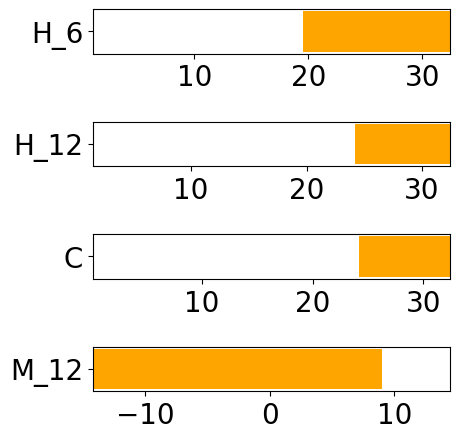

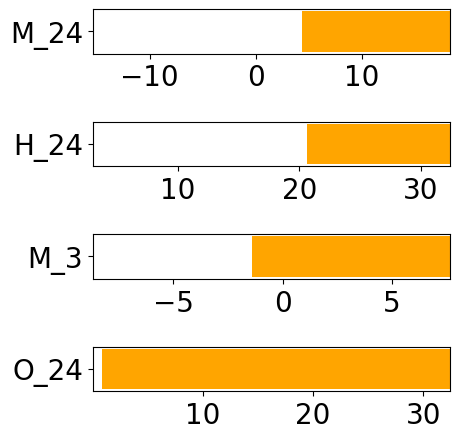

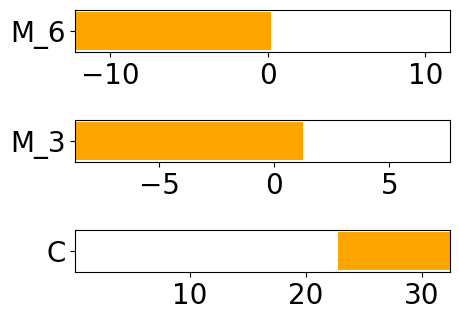

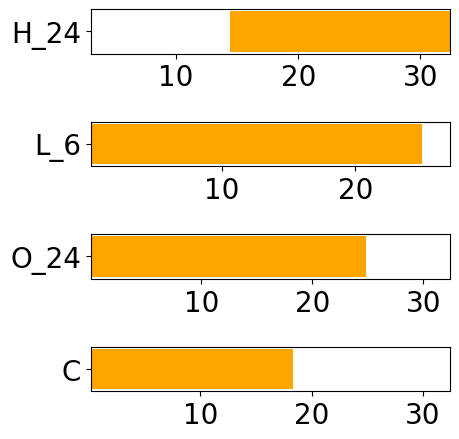

In [86]:
for i in used_conc:
    plot_concept(X_tr,all_the_rules[i],scaler,i)